In [3]:
import torch
import torchvision
from torchvision.datasets.utils import download_and_extract_archive

# Good library for various image transformations
import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
from PIL import Image
import numpy as np

from tqdm import tqdm

from IPython import display
import matplotlib.pyplot as plt

C:\Users\msaur\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Some Configuration:

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_EPOCHS = 500
NUM_WORKERS = 2
IMAGE_SIZE = 256
CHANNELS_IMG = 3
LAMBDA_L1 = 100
LOAD_MODEL = True
SAVE_MODEL = True
CHECKPOINT_GEN = "gen.pth.tar"
CHECKPOINT_DISC = "disc.pth.tar"

both_transform = A.Compose(
    [A.Resize(width=256, height=256)], 
    additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ],
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0),
        ToTensorV2()
    ],
)

### Getting Map Dataset:
For training the model, we would be using the same dataset as used by the pix2pix authors, which is publicly availabe.

*   Dataset Url : http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
*   Dataset Size : 240 MB

In [6]:
dataset_name = "maps"
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

# Downloading and extracting the dataset
download_and_extract_archive(_URL, download_root='../', extract_root='../', remove_finished=True)

100.0%


Extracting ../maps.tar.gz to ../


After extracting the dataset we will be loading training dataset from the maps folder.

In [5]:
# Defining the dataset loader function
class MapDatasetLoader(torch.utils.data.Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.files = os.listdir(self.root_dir)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_file = self.files[idx]
        img_path = os.path.join(self.root_dir, img_file)
        image = np.array(Image.open(img_path))
        input_img = image[:, :600, :]
        target_img = image[:, 600:, :]

        augmented = both_transform(image=input_img, image0=target_img)
        input_img, target_img = augmented["image"], augmented["image0"]
        input_img = transform_only_input(image=input_img)["image"]
        target_img = transform_only_mask(image=target_img)["image"]

        return input_img, target_img
        

In [6]:
# Loading training dataset
# Replace the path with the directory where you have extracted the dataset
data_path = '../../maps/train'
dataset = MapDatasetLoader(data_path)
print('Number of training examples:', len(dataset))

Number of training examples: 1096


Plotting a random image from the dataset to see how the images look like.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


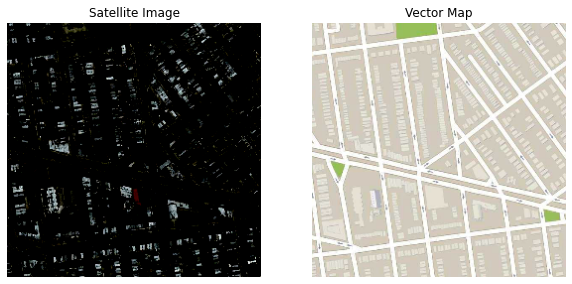

In [7]:
(satellite, map) = dataset[0]
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Satellite Image')
plt.imshow(satellite.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(map.permute(1, 2, 0))
plt.axis('off')
plt.title('Vector Map')
plt.show()

### Some Utility Functions:

In [8]:
def save_checkpoint(model, optimizer, filename = 'my_checkpoint.pth.tar'):
    print('=> Saving checkpoint')
    checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print('=> Loading Checkpoint')
    checkpoint = torch.load(checkpoint_file, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    # Update learning rate
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def save_example(gen, val_loader, epoch, folder):
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        # Remove Normalization
        y_fake = y_fake * 0.5 + 0.5
        torchvision.utils.save_image(y_fake, f'{folder}/generated_{epoch}.png')
        torchvision.utils.save_image(x * 0.5 + 0.5, f'{folder}/real_{epoch}.png')
        if epoch == 1:
            torchvision.utils.save_image(y * 0.5 + 0.5, f'{folder}/target_{epoch}.png')
    gen.train()

### Some Important Components For GAN Architecture:

In [9]:
class Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act='relu', use_dropout=False):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode='reflect') 
            if down 
            else torch.nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU() if act == 'relu' else torch.nn.LeakyReLU(0.2)
        )
        self.use_dropout = use_dropout
        self.dropout = torch.nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

In [10]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        ) # 128
        self.down1 = Block(features, features * 2, down=True, use_dropout=False, act='leaky') # 64
        self.down2 = Block(features * 2, features * 4, down=True, use_dropout=False, act='leaky') # 32
        self.down3 = Block(features * 4, features * 8, down=True, use_dropout=False, act='leaky') # 16
        self.down4 = Block(features * 8, features * 8, down=True, use_dropout=False, act='leaky') # 8
        self.down5 = Block(features * 8, features * 8, down=True, use_dropout=False, act='leaky') # 4
        self.down6 = Block(features * 8, features * 8, down=True, use_dropout=False, act='leaky') # 2

        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode='reflect'), # 1
        )

        self.up1 = Block(features * 8, features * 8, down=False, use_dropout=True, act='relu') # 4
        self.up2 = Block(features * 8 * 2, features * 8, down=False, use_dropout=True, act='relu') # 8
        self.up3 = Block(features * 8 * 2, features * 8, down=False, use_dropout=True, act='relu') # 16
        self.up4 = Block(features * 8 * 2, features * 8, down=False, use_dropout=False, act='relu') # 32
        self.up5 = Block(features * 8 * 2, features * 4, down=False, use_dropout=False, act='relu') # 64
        self.up6 = Block(features * 4 * 2, features * 2, down=False, use_dropout=False, act='relu') # 128
        self.up7 = Block(features * 2 * 2, features, down=False, use_dropout=False, act='relu') # 256

        self.final_up = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(features * 2, in_channels, 4, 2, 1),
            torch.nn.Tanh()
        )
    
    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d7] , 1))
        up3 = self.up3(torch.cat([up2, d6] , 1))
        up4 = self.up4(torch.cat([up3, d5] , 1))
        up5 = self.up5(torch.cat([up4, d4] , 1))
        up6 = self.up6(torch.cat([up5, d3] , 1))
        up7 = self.up7(torch.cat([up6, d2] , 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [11]:
class CNNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode='reflect'),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.LeakyReLU(0.2)
        )
    
    def forward(self, x):
        return self.conv(x)

In [12]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super(Discriminator, self).__init__()
        self.initial = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels*2, features[0], kernel_size=4, stride=2, padding=1, padding_mode='reflect'),
            torch.nn.LeakyReLU(0.2)
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            torch.nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'
            )
        )
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [13]:
def test_dis():
    x = torch.randn((1, 3, 256, 256))
    y = torch.randn((1, 3, 256, 256))
    model = Discriminator()
    preds = model(x, y)
    print('Discriminator Output Shape:',preds.shape)

def test_gen():
    x = torch.randn((1, 3, 256, 256))
    model = Generator(in_channels=3, features=64)
    preds = model(x)
    print('Generator Output Shape:',preds.shape)

test_dis()
test_gen()

Discriminator Output Shape: torch.Size([1, 1, 26, 26])
Generator Output Shape: torch.Size([1, 3, 256, 256])


### Training GAN Model:

In [54]:
def train(disc, gen, loader, opt_disc, opt_gen, g_scaler, d_scaler, l1, bce):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)

        # Train Discriminator
        with torch.cuda.amp.autocast():
            y_fake = gen(x)
            d_real = disc(x, y)
            d_fake = disc(x, y_fake.detach())
            d_real_loss = bce(d_real, torch.ones_like(d_real))
            d_fake_loss = bce(d_fake, torch.zeros_like(d_fake))
            d_loss = (d_real_loss + d_fake_loss) / 2
        
        disc.zero_grad()
        d_scaler.scale(d_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        # Train Generator
        with torch.cuda.amp.autocast():
            d_fake = disc(x, y_fake)
            g_fake_loss = bce(d_fake, torch.ones_like(d_fake))
            L1 = l1(y_fake, y) * LAMBDA_L1
            g_loss = g_fake_loss + L1
        
        opt_gen.zero_grad()
        g_scaler.scale(g_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()

In [55]:
def main():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = torch.nn.BCEWithLogitsLoss()
    L1_LOSS = torch.nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)
    
    # Replace the path with the directory where you have extracted the dataset
    train_dataset_path = '../../maps/train'
    train_dataset = MapDatasetLoader(root_dir=train_dataset_path)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
        #num_workers=NUM_WORKERS
    )

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    val_dataset_path = '../../maps/val'
    val_dataset = MapDatasetLoader(root_dir=val_dataset_path)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

    for epoch in range(NUM_EPOCHS):
        train(disc, gen, train_loader, opt_disc, opt_gen, g_scaler, d_scaler, L1_LOSS, BCE)
        if SAVE_MODEL and epoch % 5 == 0:
            save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
            save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)
        if epoch % 20 == 0:
            save_example(gen, val_loader, epoch, folder='evaluation_images')

In [ ]:
if __name__ == '__main__':
    main()

In [19]:
# Generating all the validation images
def validationImages():
    disc = Discriminator(in_channels=3).to(DEVICE)
    gen = Generator(in_channels=3).to(DEVICE)
    opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
    BCE = torch.nn.BCEWithLogitsLoss()
    L1_LOSS = torch.nn.L1Loss()

    if LOAD_MODEL:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

    g_scaler = torch.cuda.amp.GradScaler()
    d_scaler = torch.cuda.amp.GradScaler()

    val_dataset_path = '../../maps/val'
    val_dataset = MapDatasetLoader(root_dir=val_dataset_path)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False)

    #save_example(gen, val_loader, 'final', folder='evaluation_images')
    x, y = next(iter(val_loader))
    x, y = x.to(DEVICE), y.to(DEVICE)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        # Remove Normalization
        y_fake = y_fake * 0.5 + 0.5
        torchvision.utils.save_image(y_fake, f'val_generated_images/generated_final.png')
        torchvision.utils.save_image(x * 0.5 + 0.5, f'val_generated_images/real_final.png')
        torchvision.utils.save_image(y * 0.5 + 0.5, f'val_generated_images/target_final.png')
    gen.train()

In [20]:
validationImages()

=> Loading Checkpoint
=> Loading Checkpoint
